In [54]:
!pip install nltk
!pip install gensim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop_words = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alimurad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alimurad/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [29]:
!wget https://github.com/stanfordnlp/GloVe/blob/master/glove.twitter.27B.25d.txt
embedding_dict = {}
with open("glove.twitter.27B.25d.txt", 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector


zsh:1: command not found: wget


In [32]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head(3)
print('There are {} rows and {} columns in the training data'.format(train_data.shape[0], train_data.shape[1]))
print('There are {} rows and {} columns in the test data'.format(test_data.shape[0], test_data.shape[1]))


There are 7613 rows and 5 columns in the training data
There are 3263 rows and 4 columns in the test data


Text(0, 0.5, 'samples')

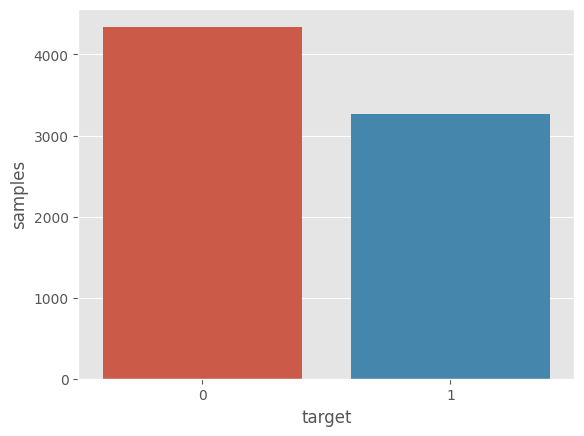

In [33]:
x = train_data.target.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('samples')


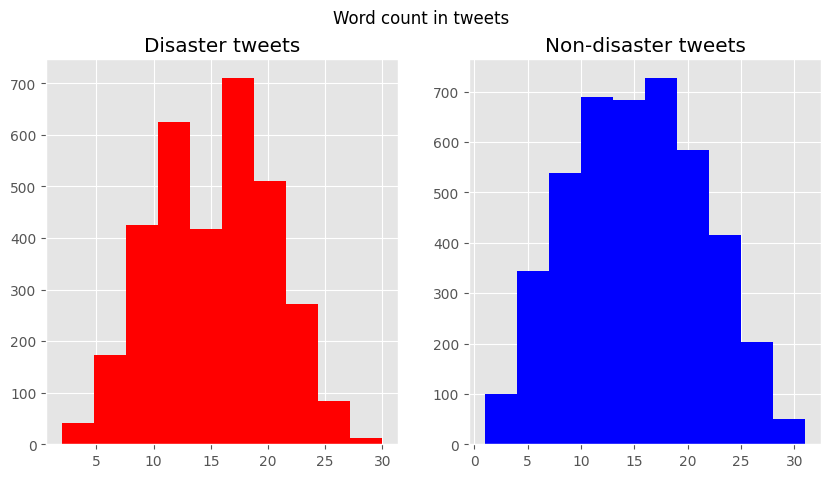

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = train_data[train_data['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color='red')
ax1.set_title('Disaster tweets')
tweet_len = train_data[train_data['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='blue')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Word count in tweets')
plt.show()


In [35]:
plt.style.use('ggplot')
stop = set(stopwords.words('english'))


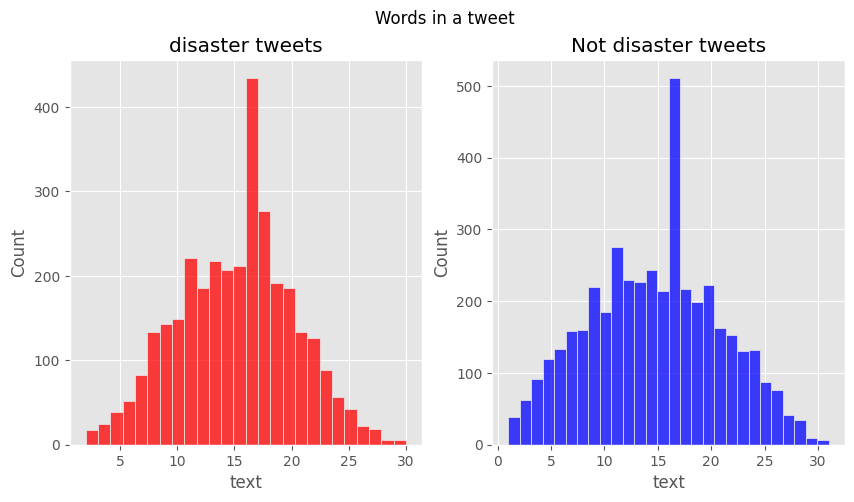

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = train_data[train_data['target'] == 1]['text'].str.split().map(lambda x: len(x))
sns.histplot(tweet_len, ax=ax1, color='red')
ax1.set_title('disaster tweets')
tweet_len = train_data[train_data['target'] == 0]['text'].str.split().map(lambda x: len(x))
sns.histplot(tweet_len, ax=ax2, color='blue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


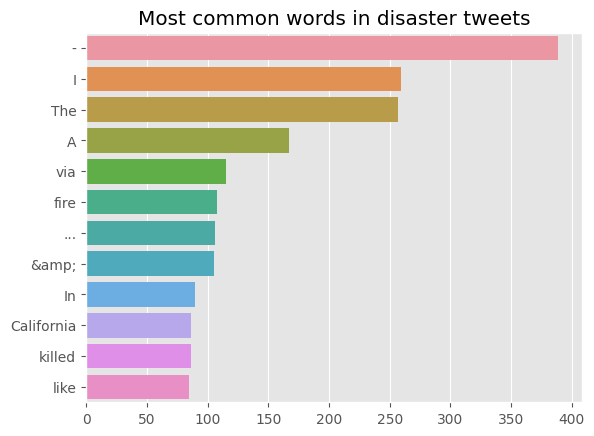

In [41]:
def create_corpus(target_data, target):
    corpus = []
    for x in target_data[target_data['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus = create_corpus(train_data, target=1)

counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x)
plt.title('Most common words in disaster tweets')
plt.show()


In [42]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


In [43]:
df = pd.concat([train_data, test_data])
df.shape


(10876, 5)

In [44]:
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


In [45]:
example = "Click on this link: https://www.example.com"
print(remove_url(example))
df['text'] = df['text'].apply(lambda x: remove_url(x))


Click on this link: 


In [46]:
def remove_html_tags(text):
    html_pattern = re.compile(r'<.*?>')
    return html_pattern.sub(r'', text)


In [47]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

print(remove_html_tags(example))
df['text'] = df['text'].apply(lambda x: remove_html_tags(x))



Real or Fake
Kaggle 
getting started



In [48]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [49]:
example = remove_emojis("second Earthquake 😔😔")
print(remove_emojis(example))
df['text'] = df['text'].apply(lambda x: remove_emojis(x))


second Earthquake 


In [50]:
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


In [51]:
example = "I @am the #best"
print(remove_punctuation(example))
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))


I am the best


In [52]:
def remove_stopwords(text):
    words = [word.lower() for word in word_tokenize(text) if word.lower() not in stop_words]
    return " ".join(words)


In [55]:
example = "I am a very good boy, but I don't like to study"
print(remove_stopwords(example))
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))


good boy , n't like study


In [56]:
corpus = df['text'].apply(lambda x: word_tokenize(x))
num_words = len(corpus)
embedding_dict = gensim.models.Word2Vec(corpus, vector_size=100, window=5, min_count=2)
max_seq_len = 100
embed_num_dims = 25


In [57]:
X = train_data['text']
y = train_data['target']

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_seq_len)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
lstm_out = 128
batch_size = 32
num_epochs = 1


In [59]:
model = Sequential()
model.add(Embedding(10000, embed_num_dims, input_length=max_seq_len))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))


203/203 [==============================] - 34s 145ms/step - loss: 0.5849 - accuracy: 0.6959 - val_loss: 0.4640 - val_accuracy: 0.7986


In [60]:
embed_num_dims = 100
max_seq_len = X.shape[1]
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)


In [61]:
def create_embedding_matrix(word_index, embedding_dict, embed_num_dims):
    embedding_matrix = np.zeros((len(word_index) + 1, embed_num_dims))
    for word, index in word_index.items():
        if word in embedding_dict.wv.key_to_index:
            embedding_matrix[index] = embedding_dict.wv[word]

        return embedding_matrix


In [62]:
embedding_matrix = create_embedding_matrix(word_index, embedding_dict, embed_num_dims)


In [63]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    embed_num_dims,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_seq_len,
                    trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [64]:
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

history = model.fit(X_train, y_train, batch_size=4, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
1618/1618 [==============================] - 80s 48ms/step - loss: 0.6911 - accuracy: 0.5647 - val_loss: 0.6860 - val_accuracy: 0.5919
Epoch 2/5
1618/1618 [==============================] - 73s 45ms/step - loss: 0.6856 - accuracy: 0.5665 - val_loss: 0.6780 - val_accuracy: 0.5919
Epoch 3/5
1618/1618 [==============================] - 69s 43ms/step - loss: 0.6846 - accuracy: 0.5665 - val_loss: 0.6776 - val_accuracy: 0.5919
Epoch 4/5
1618/1618 [==============================] - 73s 45ms/step - loss: 0.6844 - accuracy: 0.5665 - val_loss: 0.6779 - val_accuracy: 0.5919
Epoch 5/5
1618/1618 [==============================] - 68s 42ms/step - loss: 0.6844 - accuracy: 0.5665 - val_loss: 0.6777 - val_accuracy: 0.5919


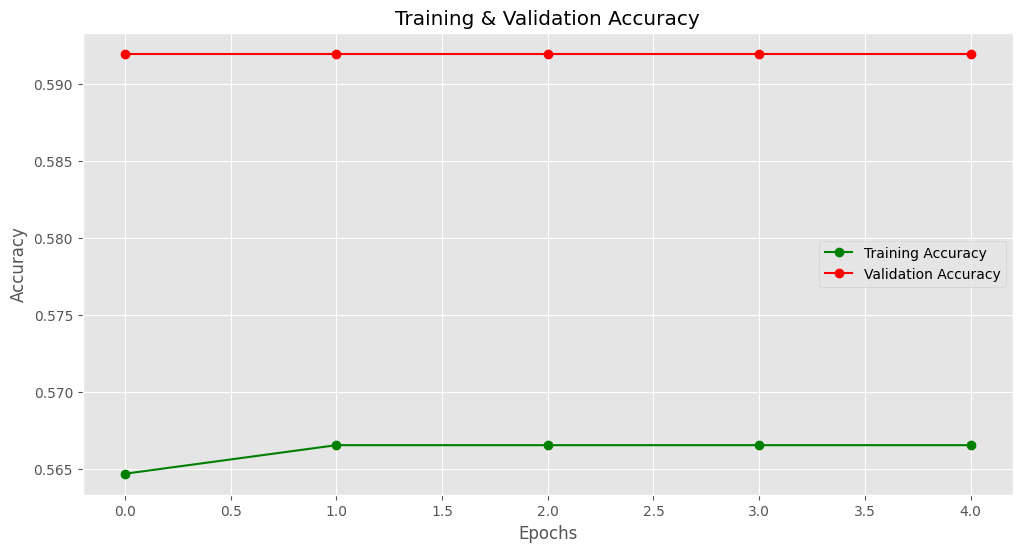

In [76]:
epochs = [i for i in range(5)]

plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['accuracy'], 'go-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [66]:
loss, accuracy = model.evaluate(X_test, y_test)


36/36 [==============================] - 0s 8ms/step - loss: 0.6777 - accuracy: 0.5919


In [68]:
sample_sub=pd.read_csv('train.csv')
y_pre=model.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(1, -1)[0]
sub = pd.concat([sample_sub['id'], pd.Series(y_pre, name='target')], axis=1)
sub.to_csv('submission.csv', index=False)
sub.head()


36/36 [==============================] - 1s 8ms/step


,id,target
0,1,0.0
1,4,0.0
2,5,0.0
3,6,0.0
4,7,0.0


In [70]:
dataset = pd.read_csv('train.csv')
embedding_dim=25
embedding_dict = {}
with open('glove.twitter.27B.25d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = coefs


In [71]:
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [72]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_seq_len, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

epochs = 10
batch_size = 32
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/10
203/203 [==============================] - 12s 48ms/step - loss: 0.7195 - accuracy: 0.4242 - val_loss: 0.7093 - val_accuracy: 0.3765
Epoch 2/10
203/203 [==============================] - 8s 41ms/step - loss: 0.7016 - accuracy: 0.4738 - val_loss: 0.6903 - val_accuracy: 0.5254
Epoch 3/10
203/203 [==============================] - 9s 42ms/step - loss: 0.6885 - accuracy: 0.5379 - val_loss: 0.6763 - val_accuracy: 0.5832
Epoch 4/10
203/203 [==============================] - 9s 43ms/step - loss: 0.6792 - accuracy: 0.5718 - val_loss: 0.6648 - val_accuracy: 0.6112
Epoch 5/10
203/203 [==============================] - 9s 43ms/step - loss: 0.6708 - accuracy: 0.5981 - val_loss: 0.6553 - val_accuracy: 0.6436
Epoch 6/10
203/203 [==============================] - 9s 42ms/step - loss: 0.6635 - accuracy: 0.6160 - val_loss: 0.6460 - val_accuracy: 0.6646
Epoch 7/10
203/203 [==============================] - 9s 43ms/step - loss: 0.6559 - accuracy: 0.6378 - val_loss: 0.6380 - val_accuracy: 0.673

In [73]:
new_data = ['your text data goes here', 'more text data']
new_sequences = tokenizer.texts_to_sequences(new_data)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_seq_len)
predictions = model.predict(new_padded_sequences)


1/1 [==============================] - 0s 244ms/step


In [74]:
y_pre=model.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(1, -1)[0]
sub = pd.concat([sample_sub['id'], pd.Series(y_pre, name='target')], axis=1)
sub.to_csv('submission.csv', index=False)
sub.head()


36/36 [==============================] - 0s 9ms/step


,id,target
0,1,1.0
1,4,0.0
2,5,0.0
3,6,0.0
4,7,0.0


In [75]:
loss, accuracy = model.evaluate(X_test, y_test)

36/36 [==============================] - 0s 8ms/step - loss: 0.6151 - accuracy: 0.6804
